In [1]:
import cv2
import numpy as np

# Diámetros conocidos de las monedas en mm
diametro_monedas = {
    '2 euros': 25.75, '1 euro': 23.25, '50 cents': 24.35,
    '20 cents': 22.25, '10 cents': 19.75, '5 cents': 21.25,
    '2 cents': 18.75, '1 cent': 16.25
}

valor_monedas = {
    '2 euros': 2.00, '1 euro': 1.00, '50 cents': 0.50,
    '20 cents': 0.20, '10 cents': 0.10, '5 cents': 0.05,
    '2 cents': 0.02, '1 cent': 0.01
}

monedas_detectadas = []
escala_mm_por_pixel = None  # Escala basada en 1€ (se calculará al hacer clic)

# 1. Cargar la imagen
img = cv2.imread('Monedas_prueba.jpg')
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Aplicar filtros para mejorar la detección
pimg_res = cv2.medianBlur(gris, 7)
blur = cv2.GaussianBlur(gris, (9, 9), 2)
edges = cv2.Canny(blur, 50, 200)

# 3. Detectar círculos usando HoughCircles
circ = cv2.HoughCircles(
        pimg_res,  # imagen 
        cv2.HOUGH_GRADIENT,  # tipo de detección
        1,
        100,  # distancia mínima entre círculos
        param1=115, # valor del gradiente
        param2=50, # umbral acumulador
        minRadius=50,  # radio mínimo
        maxRadius=150,  # radio máximo
    )

# 4. Procesar los círculos detectados
if circ is not None:
    circ = np.round(circ[0, :]).astype("int")
    for (x, y, r) in circ:
        # Dibujar cada círculo detectado en la imagen original
        cv2.circle(img, (x, y), r, (0, 255, 0), 2)

        # Guardar información de la moneda detectada
        monedas_detectadas.append({
            'x': x, 'y': y, 'r': r, 'valor': "Desconocida", 'x_original': x, 'y_original': y, 'r_original': r
        })

# 5. Función de clic para identificar monedas (ajustando coordenadas)
def seleccion_moneda(event, x, y, flags, param):
    global escala_mm_por_pixel

    if event == cv2.EVENT_LBUTTONDOWN:
        for moneda in monedas_detectadas:
            #Calculamos las areas
            area = np.sqrt((x - moneda['x_original']) ** 2 + (y - moneda['y_original']) ** 2)
            #Miramos si el click es dentro de una moneda
            if area <= moneda['r_original']:
                # Asumimos que la moneda seleccionada es de 1€
                if escala_mm_por_pixel is None:  # Solo asignamos valor si no se ha hecho
                    escala_mm_por_pixel = 23.25 / (2 * moneda['r_original'])  #proporcion mm/pixel del diámetro
                    print(f"Escala establecida: {escala_mm_por_pixel:.4f} mm/píxel")

                    # Asignar valor a la moneda seleccionada
                    moneda['valor'] = '1 euro'

                    # Asignar valor a todas las monedas detectadas en función de la escala
                    for m in monedas_detectadas:
                        if m['valor'] == "Desconocida":
                            diametro_estimado_mm = (2 * m['r']) * escala_mm_por_pixel
                            m['valor'] = asignar_valor(diametro_estimado_mm)

           
                print(f"Moneda seleccionada: {moneda['valor']}, Diámetro: {2 * moneda['r_original'] * escala_mm_por_pixel:.2f} mm")
                break


# 6. Asignar valor a la moneda según el diámetro en mm filtrando con tolerancia grande
def asignar_valor(diametro_mm):
    print(f"diametro: {diametro_mm}")

    mejor_coincidencia = None
    menor_diferencia = 100.0  # Inicializa con un valor muy grande

    for nombre, diametro in diametro_monedas.items():
        # Verifica si la diferencia es menor que la menor diferencia actual
        diferencia=abs(diametro - diametro_mm)
        if  diferencia <= 3:  # Tolerancia de ±2 mm
            if diferencia < menor_diferencia:
                menor_diferencia = diferencia
                mejor_coincidencia = nombre

    return mejor_coincidencia if mejor_coincidencia else "Desconocida"



# Hacer que la ventana no se salga de la pantalla 
cv2.namedWindow("Monedas Detectadas", cv2.WINDOW_NORMAL)
cv2.imshow("Monedas Detectadas", img)
# Asignar la función de clic a la ventana
cv2.setMouseCallback("Monedas Detectadas", seleccion_moneda)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 7. Calcular el total de dinero detectado
# Inicializar la variable total_dinero
total_dinero = 0.0
# Recorrer cada moneda detectada
for moneda in monedas_detectadas:
    # Obtener el valor de la moneda usando el nombre como clave
    valor = valor_monedas.get(moneda['valor'], 0)  #accedemos al valor del diccionario
    # Sumar el valor al total
    total_dinero += valor

# 8. Mostrar el resumen de monedas detectadas
print("\nResumen de Monedas Detectadas:")
for moneda in monedas_detectadas:
    print(f"{moneda['valor']}")

print(f"\nCantidad Total de Dinero: {total_dinero:.2f} €")

Escala establecida: 0.1097 mm/píxel
diametro: 27.63679245283019
diametro: 24.566037735849058
diametro: 22.37264150943396
diametro: 21.933962264150946
diametro: 22.37264150943396
diametro: 20.617924528301888
diametro: 17.985849056603776
Moneda seleccionada: 1 euro, Diámetro: 23.25 mm
Moneda seleccionada: 2 euros, Diámetro: 27.64 mm
Moneda seleccionada: 20 cents, Diámetro: 21.93 mm
Moneda seleccionada: 50 cents, Diámetro: 24.57 mm
Moneda seleccionada: 5 cents, Diámetro: 20.62 mm
Moneda seleccionada: 20 cents, Diámetro: 22.37 mm
Moneda seleccionada: 2 cents, Diámetro: 17.99 mm

Resumen de Monedas Detectadas:
2 euros
50 cents
20 cents
1 euro
20 cents
20 cents
5 cents
2 cents

Cantidad Total de Dinero: 4.17 €


El objetivo de la siguiente tarea, descrita más abajo, es desarrollar tu propio clasificador basado únicamente en heurísticas desde características geométricas y/o de apariencia, para distinguir en las imágenes completas, las partículas de cada tipo, debiendo mostrar la bondad del clasificador haciendo uso de métricas para ello. La siguiente celda obtiene varias métricas para un conjunto de datos imaginario (y con etiquetas aleatorias). Si bien las trataremos con más detalle en teoría, muestro un repertorio de ellas, dando más peso a la matriz de confusión. La ejecución de la celda requiere instalar el paquete scikit-learn.

¿Qué es una matriz de confusión?
Se utiliza para mostrar el comportamiento de un clasificador para las distintas clases conocidas, se relacionan las etiquetas de las muestras anotadas frente a las predichas por el clasificador. Se busca una matriz diagonal, pero la perfección es infrecuente.

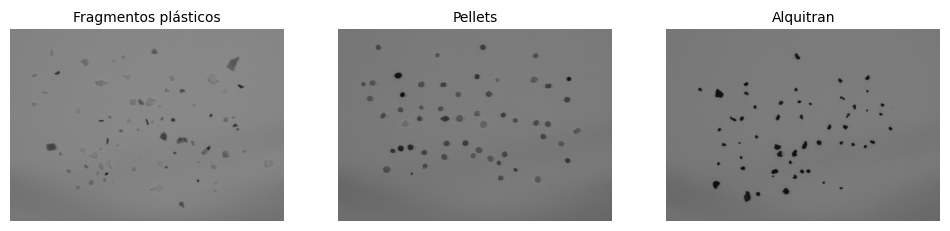

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# Cargamos las imágenes
frag_plast = cv2.imread('fragment-03-olympus-10-01-2020.JPG')
pellets = cv2.imread('pellet-03-olympus-10-01-2020.JPG')
alquitran = cv2.imread('tar-03-olympus-10-01-2020.JPG')

# Parámetros para recortar las imágenes
roi_x, roi_y, roi_x_end, roi_y_end = 500, 100, 4350, 2800
frag_plast_roi = frag_plast[roi_y:roi_y_end, roi_x:roi_x_end]
pellets_roi = pellets[roi_y:roi_y_end, roi_x:roi_x_end]
alquitran_roi = alquitran[roi_y:roi_y_end, roi_x:roi_x_end]

# Imágenes a escala de grises
frag_plast_gris = cv2.cvtColor(frag_plast_roi, cv2.COLOR_BGR2GRAY)
pellets_gris = cv2.cvtColor(pellets_roi, cv2.COLOR_BGR2GRAY)
alquitran_gris = cv2.cvtColor(alquitran_roi, cv2.COLOR_BGR2GRAY)

# Suavizado para reducción de ruido
frag_plast_gris_b = cv2.GaussianBlur(frag_plast_gris, (25, 25), 0)
pellets_gris_b = cv2.GaussianBlur(pellets_gris, (9, 9), 0)
alquitran_gris_b = cv2.GaussianBlur(alquitran_gris, (9, 9), 0)

# Mostramos las imágenes suavizadas
plt.figure(figsize=(12, 3))

plt.subplot(131)
plt.imshow(cv2.cvtColor(frag_plast_gris_b, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Fragmentos plásticos", fontsize=10)

plt.subplot(132)
plt.imshow(cv2.cvtColor(pellets_gris_b, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Pellets", fontsize=10)

plt.subplot(133)
plt.imshow(cv2.cvtColor(alquitran_gris_b, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Alquitran", fontsize=10)



plt.show()

Text(0.5, 1.0, 'Alquitran')

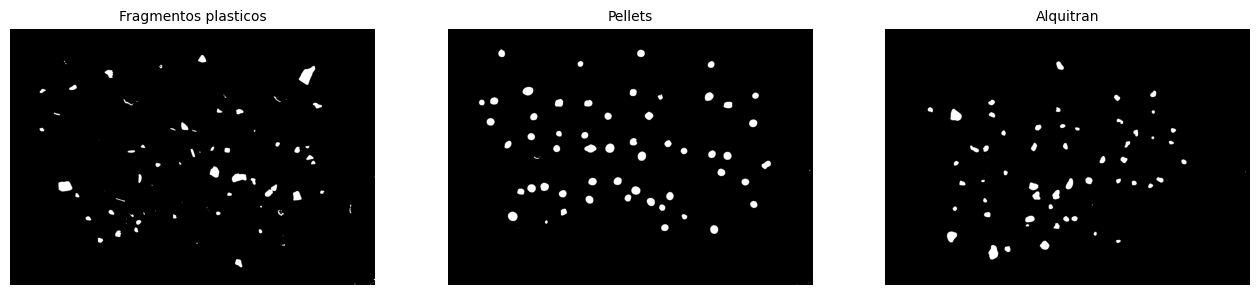

In [3]:
# Umbralizado binario de las imágenes para detectar partículas
_, frag_plast_threshold = cv2.threshold(frag_plast_gris_b, 112, 255, cv2.THRESH_BINARY_INV)
_, pellets_threshold = cv2.threshold(pellets_gris_b, 101, 255, cv2.THRESH_BINARY_INV)
_, alquitran_threshold = cv2.threshold(alquitran_gris_b, 95, 255, cv2.THRESH_BINARY_INV)

# Mostramos las imágenes umbralizadas
plt.figure(figsize=(16, 4))

plt.subplot(131)
plt.imshow(frag_plast_threshold, cmap='gray')
plt.axis("off")
plt.title("Fragmentos plasticos", fontsize=10)

plt.subplot(132)
plt.imshow(pellets_threshold, cmap='gray')
plt.axis("off")
plt.title("Pellets", fontsize=10)

plt.subplot(133)
plt.imshow(alquitran_threshold, cmap='gray')
plt.axis("off")
plt.title("Alquitran", fontsize=10)


Número de fragmentos de plástico encontrados: (51, 9, 29)
Número de pellets encontrados: (6, 50, 8)
Número de partículas de alquitrán encontradas: (7, 18, 34)


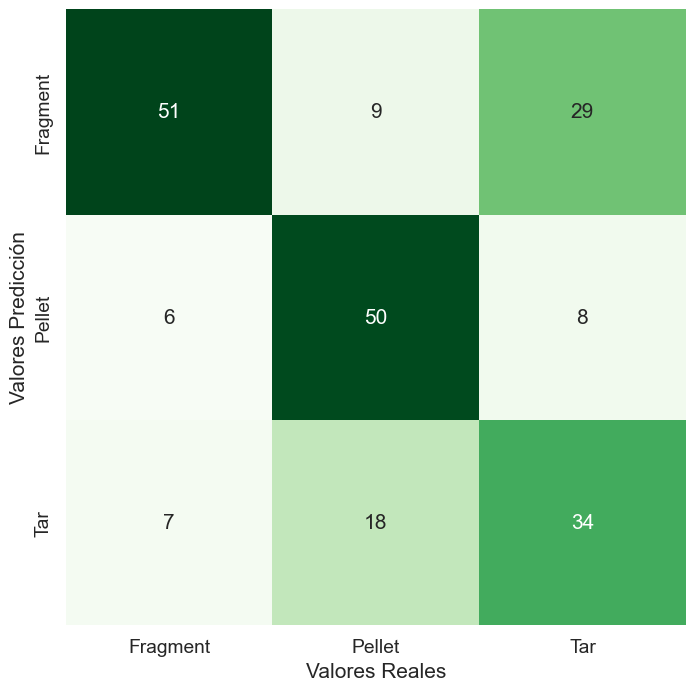

In [4]:
def contar_particulas(imagen):
    """
    Función que cuenta partículas a partir de una imagen dada.

    :parameters: Imagen a analizar
    :return: Número de fragmentos plásticos, pellets y alquitrán detectados en la imagen.
    """

    # Inicialización de listas que contendrán los diferentes parámetros geométricos de las partículas
    relacion_area_cont_list = []
    compacidad_list = []            
    relacion_alto_ancho_list = []
    relacion_ejes_elipse_list = []
    circularidad_list = []

    # Inicialización de los contadores de tipo de partículas
    fragmentos=0
    pellets=0
    alquitran=0

    # Contornos encontrados en la imagen dada
    contornos, _ = cv2.findContours(imagen, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Recorremos todos los contornos encontrados para analizar sus características
    for contorno in contornos:

        # Ancho y alto del rectángulo que contiene la partícula       
        _, _, w, h = cv2.boundingRect(contorno)

        # Área y perímetro de los fragmentos
        area = cv2.contourArea(contorno)       
        perimetro = cv2.arcLength(contorno, True)

        # Circularidad, cuán circular es la partícula
        circularidad = 4 * np.pi * (area / (perimetro ** 2))

        # Consideramos apróx a circular
        if circularidad > 0.85:
            circularidad_list.append(circularidad)
        # No es circular
        else:
            circularidad_list.append(0)

        # Si su área y perímetro es cero, calculamos su compacidad 
        if(area > 0 and perimetro > 0):
            compacidad = (perimetro ** 2) / area
        # Si no, es cero
        else:
            compacidad = 0

        # Cálculo de relaciones
        relacion_area_contenedor = area / (w*h)
        relacion_alto_ancho_contenedor = h/w

        # Si el contorno tiene al menos cinco puntos, se podrá dibujar la elipse a su alrededor
        if contorno.shape[0] >= 5:
            elipse = cv2.fitEllipse(contorno)
            sizex, sizey = elipse[1]        
            relacion_ejes_elipse = sizex/sizey
        else:
            relacion_ejes_elipse = 0

        # Guardamos los valores calculados en las listas
        relacion_area_cont_list.append(relacion_area_contenedor)
        relacion_alto_ancho_list.append(relacion_alto_ancho_contenedor)
        compacidad_list.append(compacidad)
        relacion_ejes_elipse_list.append(relacion_ejes_elipse)

    # Recorremos contornos
    for i in range(len(contornos)):

        # Descartamos la partícula si la compacidad es cero
        if compacidad_list[i] == 0:
            continue

        # Se ajusta para considerarse pellet
        if (compacidad_list[i] < 15 and np.isclose(relacion_alto_ancho_contenedor, 1.0, rtol=1)) or circularidad_list[i]!=0:
            pellets += 1
        
        # Se ajusta para considerarse fragmento plástico
        elif ((relacion_area_cont_list[i] <= 0.65) and (relacion_ejes_elipse_list[i] <= 0.75)):
            fragmentos += 1

        # Si no, consideramos como alquitrán
        else:
            alquitran+=1 
        
        
    
    return fragmentos, pellets, alquitran





print(f"Número de fragmentos de plástico encontrados: {contar_particulas(frag_plast_threshold)}")
print(f"Número de pellets encontrados: {contar_particulas(pellets_threshold)}")
print(f"Número de partículas de alquitrán encontradas: {contar_particulas(alquitran_threshold)}")



# Creamos la matriz de confusión con los datos que se obtiene de la función contar_particulas()
matriz_confusion = np.array([contar_particulas(frag_plast_threshold),contar_particulas(pellets_threshold),contar_particulas(alquitran_threshold)])


# Mostramos la matriz de confusión
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.25)
sns.heatmap(matriz_confusion, annot=True, fmt='d', cbar=False, cmap='Greens', 
            xticklabels=['Fragment', 'Pellet', 'Tar'], 
            yticklabels=['Fragment', 'Pellet', 'Tar'])
plt.xlabel("Valores Reales")
plt.ylabel("Valores Predicción")
plt.show()